In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Bull phase CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
            previous_1d      EMA_12   willr_14        OBV_7  labels
D

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

bull phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-10-07        17.00  19.847770 -84.169452 -28567700.0     2.0
2002-10-08        15.92  19.243497 -95.667449 -31364300.0     2.0
2002-10-09        17.40  18.959882 -77.411483 -28566500.0     2.0
2002-10-10        17.01  18.659901 -82.173381 -30113300.0     1.0
2002-10-11        15.57  18.184531 -92.376119 -34697400.0     2.0


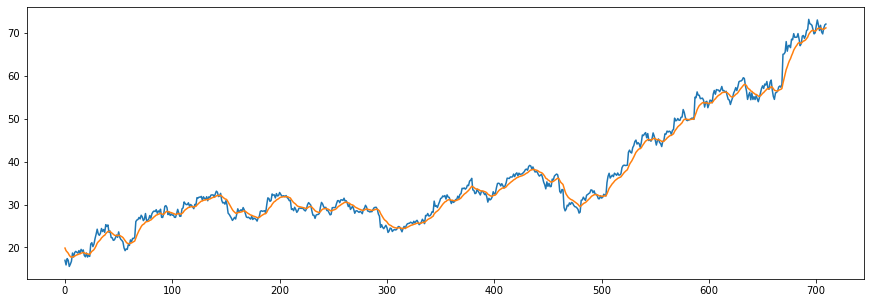

bull phase data\1_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2012-05-29    70.000000  71.826248 -83.958021  76061900.0     2.0
2012-05-30    70.400002  71.606826 -76.058610  80035500.0     2.0
2012-05-31    69.389999  71.265775 -92.508157  75357900.0     2.0
2012-06-01    69.610001  71.011041 -86.872582  79549300.0     1.0
2012-06-04    67.239998  70.430880 -98.496264  73957300.0     2.0


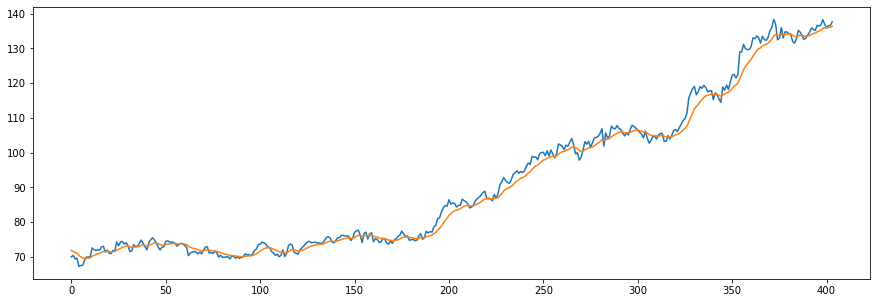

bull phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2015-09-21    17.299999  17.431825 -56.565680  1.278304e+10     2.0
2015-09-22    17.320000  17.414621 -55.892264  1.279559e+10     2.0
2015-09-23    17.389999  17.410833 -59.550566  1.281234e+10     2.0
2015-09-24    16.549999  17.278397 -94.921907  1.278454e+10     2.0
2015-09-25    16.600000  17.174028 -92.968737  1.279631e+10     2.0


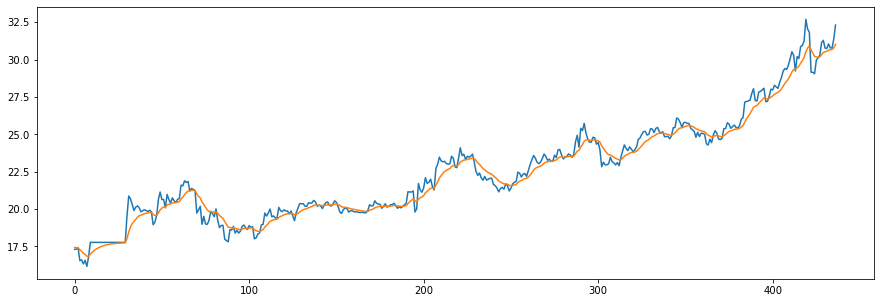

bull phase data\3_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2016-08-01         8.60  8.822459 -95.454447  221939090.0     2.0
2016-08-02         8.66  8.797466 -81.818221  229749090.0     2.0
2016-08-03         8.59  8.765548 -91.489375  223312390.0     2.0
2016-08-04         8.35  8.701618 -93.055532  213631195.0     1.0
2016-08-05         8.31  8.641369 -95.945857  207289495.0     2.0


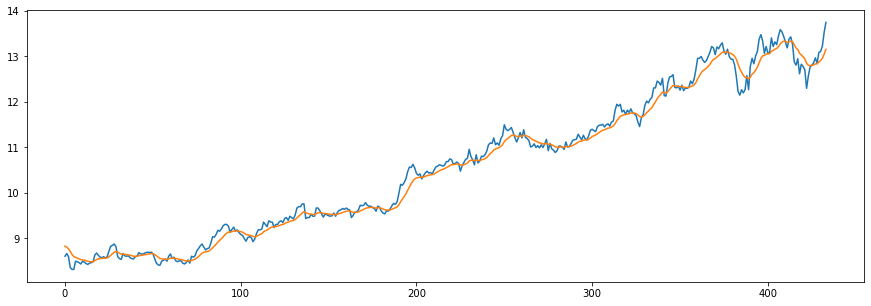

bull phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2012-05-29    33.500000  35.391902 -87.056352 -2.715978e+09     2.0
2012-05-30    33.630001  35.120840 -85.010916 -2.680123e+09     2.0
2012-05-31    32.959999  34.788403 -92.341351 -2.714327e+09     2.0
2012-06-01    33.150002  34.536341 -84.467667 -2.672202e+09     2.0
2012-06-04    31.930000  34.135366 -97.090912 -2.722674e+09     1.0


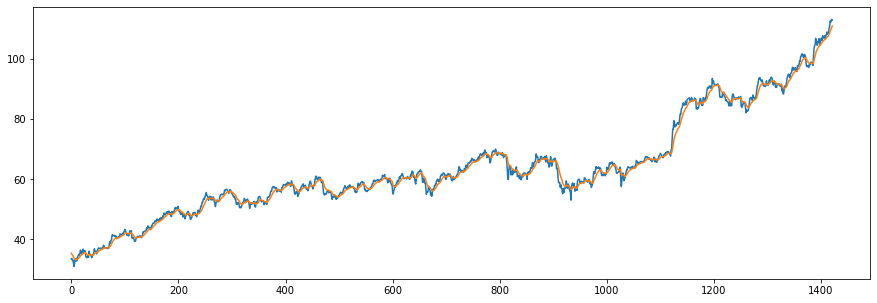

bull phase data\5_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


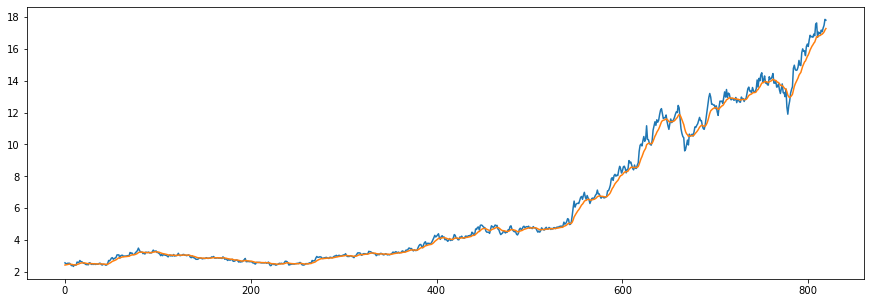

In [9]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

for filepath in glob.iglob('bull phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

In [10]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4143, 15, 1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [12]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4143, 64, 64, 1)

In [13]:
from collections import Counter

Counter(y)

Counter({0.0: 185, 2.0: 3780, 1.0: 178})

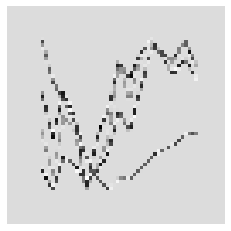

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.463963963963964, 1: 7.779342723004695, 2: 0.36529982363315694}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/26 [>.............................] - ETA: 0s - loss: 0.3643 - accuracy: 0.6875 - mse: 5.4590 - weighted_accuracy: 0.5127 - weighted_mse: 5.9962WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 27ms/step - loss: 0.2512 - accuracy: 0.3274 - mse: 1.7493 - weighted_accuracy: 0.3318 - weighted_mse: 1.7934 - val_loss: 0.2209 - val_accuracy: 0.0483 - val_mse: 0.8467 - val_weighted_accuracy: 0.0483 - val_weighted_mse: 0.8467
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.2051 - accuracy: 0.3325 - mse: 1.1923 - weighted_accuracy: 0.3569 - weighted_mse: 1.1934 - val_loss: 0.1946 

7/7 [==============================] - 0s 6ms/step - loss: 0.2022 - accuracy: 0.0685 - mse: 0.9557 - weighted_accuracy: 0.0685 - weighted_mse: 0.9557
Test loss: 0.20220038294792175
Test accuracy: 0.06849315017461777


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 46
actual holds but predicted sell: 155
actual predicted holds: 0
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 5.9880239520958085%
Percentage holds correct: 0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 48.07692307692308%
Percentage high sells correct: 40.963855421686745%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase from previously b

9/9 [==============================] - 0s 2ms/step - loss: 0.2032 - accuracy: 0.0719 - mse: 0.9426 - weighted_accuracy: 0.0719 - weighted_mse: 0.9426
Test loss: 0.20316797494888306
Test accuracy: 0.07194244861602783


number of predictions: 278
actual predicted buys: 7
actual buys but predicted sell: 9
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 12
actual sells but predicted hold: 0
actual holds but predicted buy: 60
actual holds but predicted sell: 188
actual predicted holds: 1
Percentage buys correct: 10.294117647058824%
Percentage sells correct: 5.741626794258373%
Percentage holds correct: 100.0%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 45.588235294117645%
Percentage high sells correct: 39.90384615384615%
Percentage mid holds correct: 0.0%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previous

7/7 [==============================] - 0s 5ms/step - loss: 0.2030 - accuracy: 0.0625 - mse: 0.9608 - weighted_accuracy: 0.0625 - weighted_mse: 0.9608
Test loss: 0.2029738426208496
Test accuracy: 0.0625


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 34
actual holds but predicted sell: 155
actual predicted holds: 0
Percentage buys correct: 10.256410256410257%
Percentage sells correct: 5.325443786982248%
Percentage holds correct: 0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 51.282051282051285%
Percentage high sells correct: 43.45238095238095%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previously bought: -1.539386

29/29 [==============================] - 0s 3ms/step - loss: 0.2028 - accuracy: 0.0589 - mse: 0.9586 - weighted_accuracy: 0.0589 - weighted_mse: 0.9586
Test loss: 0.2028416246175766
Test accuracy: 0.058887675404548645


number of predictions: 917
actual predicted buys: 15
actual buys but predicted sell: 31
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 38
actual sells but predicted hold: 0
actual holds but predicted buy: 172
actual holds but predicted sell: 658
actual predicted holds: 1
Percentage buys correct: 7.936507936507937%
Percentage sells correct: 5.226960110041265%
Percentage holds correct: 100.0%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 52.12765957446808%
Percentage high sells correct: 41.12792297111417%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.3088084010225731
Shares owned at the moment: 322
Cash capital at the moment: $0.2902450316259575


Price increase from pre

Epoch 1/20
26/26 [==============================] - 1s 25ms/step - loss: 0.1977 - accuracy: 0.2824 - mse: 1.1820 - weighted_accuracy: 0.3939 - weighted_mse: 1.1508 - val_loss: 0.2048 - val_accuracy: 0.0663 - val_mse: 0.9863 - val_weighted_accuracy: 0.0663 - val_weighted_mse: 0.9863
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1967 - accuracy: 0.2085 - mse: 1.1928 - weighted_accuracy: 0.3945 - weighted_mse: 1.1900 - val_loss: 0.2058 - val_accuracy: 0.0663 - val_mse: 0.9607 - val_weighted_accuracy: 0.0663 - val_weighted_mse: 0.9607
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1966 - accuracy: 0.2773 - mse: 1.2408 - weighted_accuracy: 0.4208 - weighted_mse: 1.2552 - val_loss: 0.2085 - val_accuracy: 0.0639 - val_mse: 0.9730 - val_weighted_accuracy: 0.0639 - val_weighted_mse: 0.9730
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1955 - accuracy: 0.2812 - mse: 1.1733 - weighted_accuracy: 0.4160 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.1553 - mse: 1.0031 - weighted_accuracy: 0.1553 - weighted_mse: 1.0031
Test loss: 0.1931622177362442
Test accuracy: 0.155251145362854


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 93
actual holds but predicted sell: 87
actual predicted holds: 21
Percentage buys correct: 5.05050505050505%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 91.30434782608695%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.515151515151516%
Percentage high sells correct: 47.422680412371136%
Percentage mid holds correct: 72.72727272727273%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price in

9/9 [==============================] - 0s 2ms/step - loss: 0.1936 - accuracy: 0.1763 - mse: 0.9971 - weighted_accuracy: 0.1763 - weighted_mse: 0.9971
Test loss: 0.193622887134552
Test accuracy: 0.17625899612903595


number of predictions: 278
actual predicted buys: 13
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 134
actual holds but predicted sell: 90
actual predicted holds: 25
Percentage buys correct: 8.724832214765101%
Percentage sells correct: 10.784313725490197%
Percentage holds correct: 92.5925925925926%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 43.24324324324324%
Percentage high sells correct: 48.03921568627451%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.1683 - mse: 1.0063 - weighted_accuracy: 0.1683 - weighted_mse: 1.0063
Test loss: 0.19223268330097198
Test accuracy: 0.16826923191547394


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 55
actual holds but predicted sell: 115
actual predicted holds: 19
Percentage buys correct: 12.307692307692308%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 100.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 52.30769230769231%
Percentage high sells correct: 51.21951219512195%
Percentage mid holds correct: 94.73684210526316%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increas

29/29 [==============================] - 0s 2ms/step - loss: 0.1936 - accuracy: 0.1712 - mse: 1.0034 - weighted_accuracy: 0.1712 - weighted_mse: 1.0034
Test loss: 0.19361981749534607
Test accuracy: 0.17121046781539917


number of predictions: 917
actual predicted buys: 36
actual buys but predicted sell: 6
actual buys but predicted hold: 4
actual sells but predicted buy: 4
actual predicted sells: 32
actual sells but predicted hold: 4
actual holds but predicted buy: 370
actual holds but predicted sell: 372
actual predicted holds: 89
Percentage buys correct: 8.78048780487805%
Percentage sells correct: 7.804878048780488%
Percentage holds correct: 91.75257731958763%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 49.38875305623472%
Percentage high sells correct: 47.31707317073171%
Percentage mid holds correct: 84.5360824742268%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


Pr

Epoch 1/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1841 - accuracy: 0.2598 - mse: 1.2437 - weighted_accuracy: 0.5008 - weighted_mse: 1.2284 - val_loss: 0.1825 - val_accuracy: 0.3752 - val_mse: 0.9644 - val_weighted_accuracy: 0.3752 - val_weighted_mse: 0.9644
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1857 - accuracy: 0.3126 - mse: 1.2534 - weighted_accuracy: 0.4867 - weighted_mse: 1.2440 - val_loss: 0.1910 - val_accuracy: 0.2171 - val_mse: 1.0182 - val_weighted_accuracy: 0.2171 - val_weighted_mse: 1.0182
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1866 - accuracy: 0.3470 - mse: 1.2669 - weighted_accuracy: 0.4788 - weighted_mse: 1.2567 - val_loss: 0.1915 - val_accuracy: 0.1689 - val_mse: 0.9875 - val_weighted_accuracy: 0.1689 - val_weighted_mse: 0.9875
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1821 - accuracy: 0.2677 - mse: 1.2603 - weighted_accuracy: 0.4907 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.2011 - accuracy: 0.1005 - mse: 1.1505 - weighted_accuracy: 0.1005 - weighted_mse: 1.1505
Test loss: 0.20111775398254395
Test accuracy: 0.1004566177725792


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 107
actual holds but predicted sell: 87
actual predicted holds: 7
Percentage buys correct: 5.217391304347826%
Percentage sells correct: 9.278350515463918%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.87719298245614%
Percentage high sells correct: 47.422680412371136%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase f

number of predictions: 470
actual predicted buys: 20
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 15
actual sells but predicted hold: 0
actual holds but predicted buy: 231
actual holds but predicted sell: 192
actual predicted holds: 3
Percentage buys correct: 7.8125%
Percentage sells correct: 7.109004739336493%
Percentage holds correct: 100.0%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 49.609375%
Percentage high sells correct: 54.285714285714285%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.5051713785101153
Shares owned at the moment: 197
Cash capital at the moment: $0.20756183919942828


Price increase from previously bought: 6.36758744754089%
Share price: $0.5388162889681356
Shares owned at the moment: 0
Cash capital at the moment: $106.06246704137365


Share price: $0.5797818516465718
Shares owned at the moment: 182
Cash capital at the moment

9/9 [==============================] - 0s 2ms/step - loss: 0.1984 - accuracy: 0.1403 - mse: 1.1468 - weighted_accuracy: 0.1403 - weighted_mse: 1.1468
Test loss: 0.19840218126773834
Test accuracy: 0.14028777182102203


number of predictions: 278
actual predicted buys: 15
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 149
actual holds but predicted sell: 86
actual predicted holds: 14
Percentage buys correct: 8.982035928143713%
Percentage sells correct: 10.309278350515465%
Percentage holds correct: 100.0%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 42.16867469879518%
Percentage high sells correct: 49.48453608247423%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previ

7/7 [==============================] - 0s 2ms/step - loss: 0.2026 - accuracy: 0.1010 - mse: 1.1608 - weighted_accuracy: 0.1010 - weighted_mse: 1.1608
Test loss: 0.20256465673446655
Test accuracy: 0.10096153616905212


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 70
actual holds but predicted sell: 114
actual predicted holds: 5
Percentage buys correct: 10.0%
Percentage sells correct: 6.504065040650406%
Percentage holds correct: 100.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 51.25%
Percentage high sells correct: 51.63934426229508%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 14.6852930095

Shares owned at the moment: 0
Cash capital at the moment: $42.862757039329196


Share price: $0.38875065380402474
Shares owned at the moment: 109
Cash capital at the moment: $0.3724077662127385


Price increase from previously bought: -4.564449709309637%
Share price: $0.37202659311224806
Shares owned at the moment: 0
Cash capital at the moment: $40.81179144416238


Share price: $0.3356271944946768
Shares owned at the moment: 121
Cash capital at the moment: $0.08922096133838409


Price increase from previously bought: 14.925829313869631%
Share price: $0.3867830731017402
Shares owned at the moment: 0
Cash capital at the moment: $46.76127073907434


Share price: $0.3592376000056291
Shares owned at the moment: 129
Cash capital at the moment: $0.29218079974619116


Price increase from previously bought: -1.093531856237151%
Share price: $0.3562863227716132
Shares owned at the moment: 0
Cash capital at the moment: $46.12672386428107


Share price: $0.3857992827505975
Shares owned at the momen

29/29 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.0971 - mse: 1.1535 - weighted_accuracy: 0.0971 - weighted_mse: 1.1535
Test loss: 0.20094282925128937
Test accuracy: 0.09705561399459839


number of predictions: 917
actual predicted buys: 40
actual buys but predicted sell: 6
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 32
actual sells but predicted hold: 2
actual holds but predicted buy: 446
actual holds but predicted sell: 368
actual predicted holds: 17
Percentage buys correct: 8.130081300813009%
Percentage sells correct: 7.8817733990147785%
Percentage holds correct: 89.47368421052632%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 49.08350305498982%
Percentage high sells correct: 49.01477832512315%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.07502692477278572

Epoch 1/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1636 - accuracy: 0.2520 - mse: 1.4737 - weighted_accuracy: 0.5748 - weighted_mse: 1.4399 - val_loss: 0.2044 - val_accuracy: 0.0820 - val_mse: 1.1477 - val_weighted_accuracy: 0.0820 - val_weighted_mse: 1.1477
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1652 - accuracy: 0.2538 - mse: 1.4258 - weighted_accuracy: 0.5796 - weighted_mse: 1.3905 - val_loss: 0.1971 - val_accuracy: 0.1797 - val_mse: 1.1285 - val_weighted_accuracy: 0.1797 - val_weighted_mse: 1.1285
Epoch 3/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1654 - accuracy: 0.2387 - mse: 1.4713 - weighted_accuracy: 0.5779 - weighted_mse: 1.4473 - val_loss: 0.1920 - val_accuracy: 0.1641 - val_mse: 1.1508 - val_weighted_accuracy: 0.1641 - val_weighted_mse: 1.1508
Epoch 4/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1626 - accuracy: 0.2698 - mse: 1.4028 - weighted_accuracy: 0.5896 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1851 - accuracy: 0.2557 - mse: 1.3115 - weighted_accuracy: 0.2557 - weighted_mse: 1.3115
Test loss: 0.18506883084774017
Test accuracy: 0.2557077705860138


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 83
actual holds but predicted sell: 75
actual predicted holds: 43
Percentage buys correct: 5.681818181818182%
Percentage sells correct: 9.63855421686747%
Percentage holds correct: 89.58333333333333%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.42528735632184%
Percentage high sells correct: 50.602409638554214%
Percentage mid holds correct: 77.08333333333333%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price

9/9 [==============================] - 0s 4ms/step - loss: 0.1861 - accuracy: 0.3058 - mse: 1.3238 - weighted_accuracy: 0.3058 - weighted_mse: 1.3238
Test loss: 0.18606223165988922
Test accuracy: 0.3057554066181183


number of predictions: 278
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 110
actual holds but predicted sell: 73
actual predicted holds: 66
Percentage buys correct: 8.94308943089431%
Percentage sells correct: 9.876543209876543%
Percentage holds correct: 89.1891891891892%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.26229508196721%
Percentage high sells correct: 50.617283950617285%
Percentage mid holds correct: 82.43243243243244%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.1849 - accuracy: 0.3173 - mse: 1.3360 - weighted_accuracy: 0.3173 - weighted_mse: 1.3360
Test loss: 0.18487398326396942
Test accuracy: 0.3173076808452606


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 49
actual holds but predicted sell: 88
actual predicted holds: 52
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 94.54545454545455%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.92857142857143%
Percentage high sells correct: 53.608247422680414%
Percentage mid holds correct: 85.18518518518519%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pri

29/29 [==============================] - 0s 5ms/step - loss: 0.1879 - accuracy: 0.2846 - mse: 1.3256 - weighted_accuracy: 0.2846 - weighted_mse: 1.3256
Test loss: 0.18793293833732605
Test accuracy: 0.28462377190589905


number of predictions: 917
actual predicted buys: 34
actual buys but predicted sell: 3
actual buys but predicted hold: 9
actual sells but predicted buy: 3
actual predicted sells: 29
actual sells but predicted hold: 8
actual holds but predicted buy: 336
actual holds but predicted sell: 297
actual predicted holds: 198
Percentage buys correct: 9.115281501340483%
Percentage sells correct: 8.814589665653495%
Percentage holds correct: 92.09302325581395%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 50.151975683890576%
Percentage mid holds correct: 84.65116279069767%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.1382675574590735

Epoch 1/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1510 - accuracy: 0.2752 - mse: 1.5479 - weighted_accuracy: 0.6395 - weighted_mse: 1.5688 - val_loss: 0.1894 - val_accuracy: 0.2738 - val_mse: 1.2773 - val_weighted_accuracy: 0.2738 - val_weighted_mse: 1.2773
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1473 - accuracy: 0.3144 - mse: 1.5921 - weighted_accuracy: 0.6801 - weighted_mse: 1.6212 - val_loss: 0.1948 - val_accuracy: 0.2292 - val_mse: 1.3158 - val_weighted_accuracy: 0.2292 - val_weighted_mse: 1.3158
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1509 - accuracy: 0.2852 - mse: 1.5679 - weighted_accuracy: 0.6322 - weighted_mse: 1.6043 - val_loss: 0.2024 - val_accuracy: 0.1689 - val_mse: 1.2851 - val_weighted_accuracy: 0.1689 - val_weighted_mse: 1.2851
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1498 - accuracy: 0.2839 - mse: 1.5519 - weighted_accuracy: 0.6538 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1830 - accuracy: 0.3836 - mse: 1.4284 - weighted_accuracy: 0.3836 - weighted_mse: 1.4284
Test loss: 0.18299630284309387
Test accuracy: 0.3835616409778595


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 70
actual holds but predicted sell: 59
actual predicted holds: 72
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 93.50649350649351%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.31506849315068%
Percentage high sells correct: 48.529411764705884%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Pri

Price increase from previously bought: -14.352120316757222%
Share price: $0.21700943953194973
Shares owned at the moment: 0
Cash capital at the moment: $69.70438287003239


Share price: $0.10080998010178387
Shares owned at the moment: 689
Cash capital at the moment: $0.055296870105451035


Price increase from previously bought: 114.21322654938476%
Share price: $0.21654216891523848
Shares owned at the moment: 0
Cash capital at the moment: $148.84255797815263


Share price: $0.2740188315287402
Shares owned at the moment: 541
Cash capital at the moment: $0.19069860449729958


Price increase from previously bought: 6.244849688187926%
Share price: $0.2919315056381453
Shares owned at the moment: 0
Cash capital at the moment: $157.69132205722073


Share price: $0.22323987287197
Shares owned at the moment: 704
Cash capital at the moment: $0.09825916147369185


Price increase from previously bought: 16.84311260041733%
Share price: $0.2615577271729037
Shares owned at the moment: 0
Cash capital a

9/9 [==============================] - 0s 4ms/step - loss: 0.1849 - accuracy: 0.3849 - mse: 1.4501 - weighted_accuracy: 0.3849 - weighted_mse: 1.4501
Test loss: 0.18492282927036285
Test accuracy: 0.384892076253891


number of predictions: 278
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 101
actual holds but predicted sell: 58
actual predicted holds: 90
Percentage buys correct: 9.649122807017545%
Percentage sells correct: 9.375%
Percentage holds correct: 90.0%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 43.36283185840708%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 82.0%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previously bought: 4.14546874909573

7/7 [==============================] - 0s 4ms/step - loss: 0.1854 - accuracy: 0.3606 - mse: 1.4487 - weighted_accuracy: 0.3606 - weighted_mse: 1.4487
Test loss: 0.18540170788764954
Test accuracy: 0.36057692766189575


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 50
actual holds but predicted sell: 77
actual predicted holds: 62
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 8.235294117647058%
Percentage holds correct: 93.93939393939394%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.3859649122807%
Percentage high sells correct: 49.411764705882355%
Percentage mid holds correct: 86.15384615384616%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pr

29/29 [==============================] - 0s 5ms/step - loss: 0.1879 - accuracy: 0.3381 - mse: 1.4468 - weighted_accuracy: 0.3381 - weighted_mse: 1.4468
Test loss: 0.1878969967365265
Test accuracy: 0.3380588889122009


number of predictions: 917
actual predicted buys: 32
actual buys but predicted sell: 3
actual buys but predicted hold: 11
actual sells but predicted buy: 4
actual predicted sells: 23
actual sells but predicted hold: 13
actual holds but predicted buy: 316
actual holds but predicted sell: 260
actual predicted holds: 255
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.041958041958042%
Percentage holds correct: 91.39784946236558%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.282051282051285%
Percentage high sells correct: 51.04895104895105%
Percentage mid holds correct: 84.94623655913979%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.1382675574590735


Price increase from previously bought: -5.068202707360792%
Share price: $0.8349311875049963
Shares owned at the moment: 0
Cash capital at the moment: $62.346853720687804


Share price: $0.7891016746599171
Shares owned at the moment: 78
Cash capital at the moment: $0.6276607879997158


Price increase from previously bought: -8.26703628061739%
Share price: $0.7258569853953656
Shares owned at the moment: 0
Cash capital at the moment: $57.08880932547092


Share price: $0.7221906278642736
Shares owned at the moment: 78
Cash capital at the moment: $0.6030304623806941


Price increase from previously bought: -0.27424582398404285%
Share price: $0.7221906278642736
Shares owned at the moment: 0
Cash capital at the moment: $56.778989546117145


Share price: $0.7350229229295249
Shares owned at the moment: 77
Cash capital at the moment: $0.026583376613402265


Price increase from previously bought: -1.5178533426191243%
Share price: $0.7258569853953656
Shares owned at the moment: 0
Cash capital at 

Epoch 1/20
26/26 [==============================] - 1s 19ms/step - loss: 0.1382 - accuracy: 0.3941 - mse: 1.7486 - weighted_accuracy: 0.7240 - weighted_mse: 1.8735 - val_loss: 0.1848 - val_accuracy: 0.3727 - val_mse: 1.4205 - val_weighted_accuracy: 0.3727 - val_weighted_mse: 1.4205
Epoch 2/20
26/26 [==============================] - 0s 16ms/step - loss: 0.1306 - accuracy: 0.3853 - mse: 1.7702 - weighted_accuracy: 0.7301 - weighted_mse: 1.9248 - val_loss: 0.1838 - val_accuracy: 0.3776 - val_mse: 1.6247 - val_weighted_accuracy: 0.3776 - val_weighted_mse: 1.6247
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1372 - accuracy: 0.4074 - mse: 1.7411 - weighted_accuracy: 0.7070 - weighted_mse: 1.8191 - val_loss: 0.1862 - val_accuracy: 0.3583 - val_mse: 1.6016 - val_weighted_accuracy: 0.3583 - val_weighted_mse: 1.6016
Epoch 4/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1329 - accuracy: 0.3748 - mse: 1.7417 - weighted_accuracy: 0.7085 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1659 - accuracy: 0.5525 - mse: 1.5671 - weighted_accuracy: 0.5525 - weighted_mse: 1.5671
Test loss: 0.16592127084732056
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 56
actual holds but predicted sell: 34
actual predicted holds: 111
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 15.0%
Percentage holds correct: 93.27731092436974%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.666666666666664%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 84.7457627118644%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previously

9/9 [==============================] - 0s 5ms/step - loss: 0.1692 - accuracy: 0.5144 - mse: 1.5952 - weighted_accuracy: 0.5144 - weighted_mse: 1.5952
Test loss: 0.1692357361316681
Test accuracy: 0.5143885016441345


number of predictions: 278
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 79
actual holds but predicted sell: 40
actual predicted holds: 130
Percentage buys correct: 10.989010989010989%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 90.27777777777777%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 45.05494505494506%
Percentage high sells correct: 53.48837209302326%
Percentage mid holds correct: 83.91608391608392%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Pric

19/19 [==============================] - 0s 4ms/step - loss: 0.1730 - accuracy: 0.4958 - mse: 1.5892 - weighted_accuracy: 0.4958 - weighted_mse: 1.5892
Test loss: 0.17296567559242249
Test accuracy: 0.4957983195781708


number of predictions: 595
actual predicted buys: 16
actual buys but predicted sell: 1
actual buys but predicted hold: 15
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 16
actual holds but predicted buy: 158
actual holds but predicted sell: 108
actual predicted holds: 270
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 7.627118644067797%
Percentage holds correct: 89.70099667774086%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 50.56818181818182%
Percentage high sells correct: 56.779661016949156%
Percentage mid holds correct: 83.66666666666667%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867

29/29 [==============================] - 0s 4ms/step - loss: 0.1726 - accuracy: 0.4820 - mse: 1.5883 - weighted_accuracy: 0.4820 - weighted_mse: 1.5883
Test loss: 0.17258819937705994
Test accuracy: 0.4820065498352051


number of predictions: 917
actual predicted buys: 24
actual buys but predicted sell: 3
actual buys but predicted hold: 19
actual sells but predicted buy: 2
actual predicted sells: 14
actual sells but predicted hold: 24
actual holds but predicted buy: 253
actual holds but predicted sell: 174
actual predicted holds: 404
Percentage buys correct: 8.602150537634408%
Percentage sells correct: 7.329842931937173%
Percentage holds correct: 90.38031319910515%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 53.597122302158276%
Percentage high sells correct: 52.87958115183246%
Percentage mid holds correct: 82.77404921700224%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.138267557459073

Epoch 1/20
26/26 [==============================] - 1s 20ms/step - loss: 0.1182 - accuracy: 0.5030 - mse: 1.9045 - weighted_accuracy: 0.7679 - weighted_mse: 2.2302 - val_loss: 0.1844 - val_accuracy: 0.4210 - val_mse: 1.5947 - val_weighted_accuracy: 0.4210 - val_weighted_mse: 1.5947
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1166 - accuracy: 0.4967 - mse: 1.9104 - weighted_accuracy: 0.7703 - weighted_mse: 2.2398 - val_loss: 0.1714 - val_accuracy: 0.5006 - val_mse: 1.7031 - val_weighted_accuracy: 0.5006 - val_weighted_mse: 1.7031
Epoch 3/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1161 - accuracy: 0.5063 - mse: 1.9419 - weighted_accuracy: 0.7716 - weighted_mse: 2.2581 - val_loss: 0.1724 - val_accuracy: 0.4958 - val_mse: 1.7205 - val_weighted_accuracy: 0.4958 - val_weighted_mse: 1.7205
Epoch 4/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1175 - accuracy: 0.5003 - mse: 1.8916 - weighted_accuracy: 0.7628 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1662 - accuracy: 0.5982 - mse: 1.7806 - weighted_accuracy: 0.5982 - weighted_mse: 1.7806
Test loss: 0.16620157659053802
Test accuracy: 0.5981734991073608


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 54
actual holds but predicted sell: 24
actual predicted holds: 123
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 92.4812030075188%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 60.714285714285715%
Percentage mid holds correct: 84.0909090909091%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase fr

9/9 [==============================] - 0s 8ms/step - loss: 0.1695 - accuracy: 0.5432 - mse: 1.8211 - weighted_accuracy: 0.5432 - weighted_mse: 1.8211
Test loss: 0.16949595510959625
Test accuracy: 0.5431654453277588


number of predictions: 278
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 81
actual holds but predicted sell: 28
actual predicted holds: 140
Percentage buys correct: 9.782608695652174%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 89.74358974358974%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.56521739130435%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 82.58064516129032%


Capital: 100
Share price: $0.8936259531194107
Shares owned at the moment: 111
Cash capital at the moment: $0.5347398815557085


Pric

19/19 [==============================] - 0s 6ms/step - loss: 0.1740 - accuracy: 0.5311 - mse: 1.8000 - weighted_accuracy: 0.5311 - weighted_mse: 1.8000
Test loss: 0.174016535282135
Test accuracy: 0.5310924649238586


number of predictions: 595
actual predicted buys: 15
actual buys but predicted sell: 1
actual buys but predicted hold: 16
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 19
actual holds but predicted buy: 156
actual holds but predicted sell: 85
actual predicted holds: 295
Percentage buys correct: 8.670520231213873%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 89.39393939393939%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 50.28901734104046%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 83.58662613981762%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


P

29/29 [==============================] - 0s 7ms/step - loss: 0.1733 - accuracy: 0.5005 - mse: 1.7974 - weighted_accuracy: 0.5005 - weighted_mse: 1.7974
Test loss: 0.1732678860425949
Test accuracy: 0.5005452632904053


number of predictions: 917
actual predicted buys: 22
actual buys but predicted sell: 2
actual buys but predicted hold: 22
actual sells but predicted buy: 4
actual predicted sells: 8
actual sells but predicted hold: 28
actual holds but predicted buy: 260
actual holds but predicted sell: 142
actual predicted holds: 429
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 89.5615866388309%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.578947368421055%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.25469728601253%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.07502692477278572


Price inc

Epoch 1/20
26/26 [==============================] - 1s 26ms/step - loss: 0.1043 - accuracy: 0.5999 - mse: 2.1342 - weighted_accuracy: 0.8146 - weighted_mse: 2.6938 - val_loss: 0.1530 - val_accuracy: 0.6333 - val_mse: 1.7275 - val_weighted_accuracy: 0.6333 - val_weighted_mse: 1.7275
Epoch 2/20
26/26 [==============================] - 1s 23ms/step - loss: 0.1035 - accuracy: 0.6092 - mse: 2.0983 - weighted_accuracy: 0.8159 - weighted_mse: 2.6837 - val_loss: 0.1609 - val_accuracy: 0.5826 - val_mse: 1.8089 - val_weighted_accuracy: 0.5826 - val_weighted_mse: 1.8089
Epoch 3/20
26/26 [==============================] - 1s 21ms/step - loss: 0.1020 - accuracy: 0.6177 - mse: 2.0869 - weighted_accuracy: 0.8211 - weighted_mse: 2.6554 - val_loss: 0.1484 - val_accuracy: 0.6490 - val_mse: 1.7330 - val_weighted_accuracy: 0.6490 - val_weighted_mse: 1.7330
Epoch 4/20
26/26 [==============================] - 1s 23ms/step - loss: 0.1021 - accuracy: 0.6295 - mse: 2.1115 - weighted_accuracy: 0.8077 - weighted

0          82.557937  


mark up phase data


7/7 [==============================] - 0s 9ms/step - loss: 0.1425 - accuracy: 0.6758 - mse: 2.0070 - weighted_accuracy: 0.6758 - weighted_mse: 2.0070
Test loss: 0.14245674014091492
Test accuracy: 0.6757990717887878


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 35
actual holds but predicted sell: 24
actual predicted holds: 142
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 92.20779220779221%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 59.25925925925926%
Percentage mid holds correct: 84.9673202614379%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capit

9/9 [==============================] - 0s 6ms/step - loss: 0.1471 - accuracy: 0.6691 - mse: 2.0611 - weighted_accuracy: 0.6691 - weighted_mse: 2.0611
Test loss: 0.14709703624248505
Test accuracy: 0.6690647602081299


number of predictions: 278
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 50
actual holds but predicted sell: 23
actual predicted holds: 176
Percentage buys correct: 13.559322033898304%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 91.19170984455958%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.067796610169495%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 85.41666666666667%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


P

19/19 [==============================] - 0s 6ms/step - loss: 0.1532 - accuracy: 0.6504 - mse: 2.0272 - weighted_accuracy: 0.6504 - weighted_mse: 2.0272
Test loss: 0.15321262180805206
Test accuracy: 0.6504201889038086


number of predictions: 595
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 24
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 23
actual holds but predicted buy: 94
actual holds but predicted sell: 67
actual predicted holds: 375
Percentage buys correct: 7.8431372549019605%
Percentage sells correct: 5.633802816901408%
Percentage holds correct: 88.86255924170617%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 54.90196078431372%
Percentage high sells correct: 59.15492957746479%
Percentage mid holds correct: 82.42280285035629%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867




29/29 [==============================] - 0s 6ms/step - loss: 0.1525 - accuracy: 0.6161 - mse: 2.0266 - weighted_accuracy: 0.6161 - weighted_mse: 2.0266
Test loss: 0.15251126885414124
Test accuracy: 0.6161395907402039


number of predictions: 917
actual predicted buys: 14
actual buys but predicted sell: 3
actual buys but predicted hold: 29
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 33
actual holds but predicted buy: 174
actual holds but predicted sell: 112
actual predicted holds: 545
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 4.958677685950414%
Percentage holds correct: 89.78583196046128%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 53.191489361702125%
Percentage high sells correct: 48.760330578512395%
Percentage mid holds correct: 82.53706754530478%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.138267557459073

Epoch 1/20
26/26 [==============================] - 1s 26ms/step - loss: 0.0940 - accuracy: 0.6639 - mse: 2.2979 - weighted_accuracy: 0.8202 - weighted_mse: 2.9909 - val_loss: 0.1445 - val_accuracy: 0.6791 - val_mse: 1.9249 - val_weighted_accuracy: 0.6791 - val_weighted_mse: 1.9249
Epoch 2/20
26/26 [==============================] - 1s 21ms/step - loss: 0.0899 - accuracy: 0.6832 - mse: 2.3287 - weighted_accuracy: 0.8471 - weighted_mse: 3.0784 - val_loss: 0.1278 - val_accuracy: 0.7419 - val_mse: 1.9159 - val_weighted_accuracy: 0.7419 - val_weighted_mse: 1.9159
Epoch 3/20
26/26 [==============================] - 1s 22ms/step - loss: 0.0892 - accuracy: 0.6850 - mse: 2.4139 - weighted_accuracy: 0.8348 - weighted_mse: 3.3490 - val_loss: 0.1429 - val_accuracy: 0.6852 - val_mse: 1.9291 - val_weighted_accuracy: 0.6852 - val_weighted_mse: 1.9291
Epoch 4/20
26/26 [==============================] - 1s 23ms/step - loss: 0.0860 - accuracy: 0.6889 - mse: 2.4447 - weighted_accuracy: 0.8495 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1215 - accuracy: 0.7580 - mse: 2.3002 - weighted_accuracy: 0.7580 - weighted_mse: 2.3002
Test loss: 0.12147387862205505
Test accuracy: 0.7579908967018127


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 24
actual holds but predicted sell: 14
actual predicted holds: 163
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 91.57303370786516%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 85.31073446327683%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Pr

9/9 [==============================] - 0s 6ms/step - loss: 0.1251 - accuracy: 0.7590 - mse: 2.3549 - weighted_accuracy: 0.7590 - weighted_mse: 2.3549
Test loss: 0.12514519691467285
Test accuracy: 0.7589927911758423


number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 31
actual holds but predicted sell: 13
actual predicted holds: 205
Percentage buys correct: 15.789473684210526%
Percentage sells correct: 0.0%
Percentage holds correct: 90.70796460176992%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 42.10526315789474%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 84.88888888888889%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Price increase f

19/19 [==============================] - 0s 7ms/step - loss: 0.1308 - accuracy: 0.7345 - mse: 2.3001 - weighted_accuracy: 0.7345 - weighted_mse: 2.3001
Test loss: 0.13077111542224884
Test accuracy: 0.7344537973403931


number of predictions: 595
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 24
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 23
actual holds but predicted buy: 64
actual holds but predicted sell: 46
actual predicted holds: 426
Percentage buys correct: 10.95890410958904%
Percentage sells correct: 6.122448979591836%
Percentage holds correct: 90.06342494714588%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 50.68493150684932%
Percentage high sells correct: 59.183673469387756%
Percentage mid holds correct: 83.26271186440678%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867




29/29 [==============================] - 0s 6ms/step - loss: 0.1287 - accuracy: 0.7241 - mse: 2.2874 - weighted_accuracy: 0.7241 - weighted_mse: 2.2874
Test loss: 0.12866581976413727
Test accuracy: 0.7241003513336182


number of predictions: 917
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 38
actual holds but predicted buy: 108
actual holds but predicted sell: 68
actual predicted holds: 655
Percentage buys correct: 6.837606837606837%
Percentage sells correct: 1.408450704225352%
Percentage holds correct: 89.84910836762688%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 56.03448275862069%
Percentage high sells correct: 50.70422535211268%
Percentage mid holds correct: 82.85322359396433%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.1382675574590735




Epoch 1/20
26/26 [==============================] - 1s 26ms/step - loss: 0.0765 - accuracy: 0.7299 - mse: 2.7142 - weighted_accuracy: 0.8640 - weighted_mse: 4.0484 - val_loss: 0.1276 - val_accuracy: 0.7563 - val_mse: 2.1404 - val_weighted_accuracy: 0.7563 - val_weighted_mse: 2.1404
Epoch 2/20
26/26 [==============================] - 1s 21ms/step - loss: 0.0743 - accuracy: 0.7444 - mse: 2.8231 - weighted_accuracy: 0.8605 - weighted_mse: 4.0561 - val_loss: 0.1287 - val_accuracy: 0.7419 - val_mse: 2.1554 - val_weighted_accuracy: 0.7419 - val_weighted_mse: 2.1554
Epoch 3/20
26/26 [==============================] - 1s 23ms/step - loss: 0.0748 - accuracy: 0.7402 - mse: 2.8074 - weighted_accuracy: 0.8656 - weighted_mse: 4.1097 - val_loss: 0.1099 - val_accuracy: 0.8106 - val_mse: 2.2212 - val_weighted_accuracy: 0.8106 - val_weighted_mse: 2.2212
Epoch 4/20
26/26 [==============================] - 1s 22ms/step - loss: 0.0767 - accuracy: 0.7511 - mse: 2.7840 - weighted_accuracy: 0.8634 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1164 - accuracy: 0.7808 - mse: 2.3969 - weighted_accuracy: 0.7808 - weighted_mse: 2.3969
Test loss: 0.11639934778213501
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 19
actual holds but predicted sell: 15
actual predicted holds: 167
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 92.26519337016575%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 64.70588235294117%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Pri

9/9 [==============================] - 0s 3ms/step - loss: 0.1191 - accuracy: 0.7734 - mse: 2.4443 - weighted_accuracy: 0.7734 - weighted_mse: 2.4443
Test loss: 0.11910513788461685
Test accuracy: 0.7733812928199768


number of predictions: 278
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 12
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 24
actual holds but predicted sell: 14
actual predicted holds: 211
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 6.25%
Percentage holds correct: 90.17094017094017%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 35.714285714285715%
Percentage high sells correct: 43.75%
Percentage mid holds correct: 83.2618025751073%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Price increase from previou

19/19 [==============================] - 0s 6ms/step - loss: 0.1284 - accuracy: 0.7563 - mse: 2.4204 - weighted_accuracy: 0.7563 - weighted_mse: 2.4204
Test loss: 0.12839998304843903
Test accuracy: 0.756302535533905


number of predictions: 595
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 26
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 24
actual holds but predicted buy: 48
actual holds but predicted sell: 46
actual predicted holds: 442
Percentage buys correct: 10.909090909090908%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 89.83739837398375%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 49.09090909090909%
Percentage high sells correct: 60.416666666666664%
Percentage mid holds correct: 82.89205702647658%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867




29/29 [==============================] - 0s 7ms/step - loss: 0.1260 - accuracy: 0.7426 - mse: 2.4021 - weighted_accuracy: 0.7426 - weighted_mse: 2.4021
Test loss: 0.12597708404064178
Test accuracy: 0.7426390647888184


number of predictions: 917
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 40
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 38
actual holds but predicted buy: 78
actual holds but predicted sell: 76
actual predicted holds: 677
Percentage buys correct: 3.658536585365854%
Percentage sells correct: 1.25%
Percentage holds correct: 89.66887417218543%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 54.32098765432099%
Percentage high sells correct: 46.25%
Percentage mid holds correct: 82.64900662251655%


Capital: 100
Share price: $0.31064162349454827
Shares owned at the moment: 321
Cash capital at the moment: $0.009819965110182238


Price increase from pre

In [21]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0    -22.043138
1    148.868408
2    273.111270
3    -34.710189
4    585.168062
5     -3.590779
6    -12.606001
Name: Profit gained, dtype: float64

In [22]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


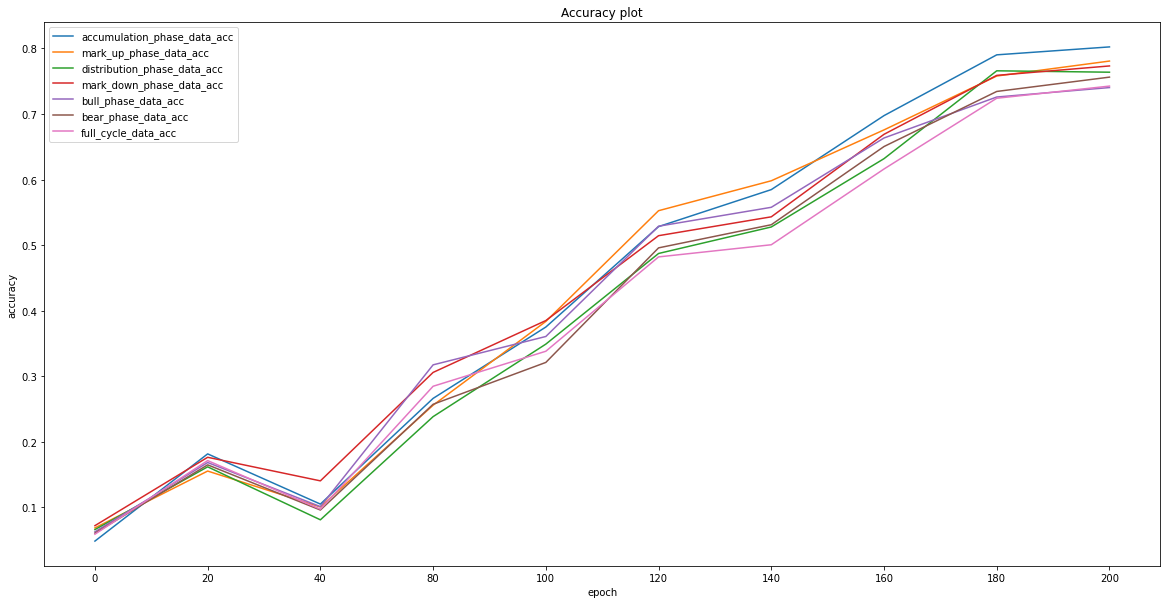

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

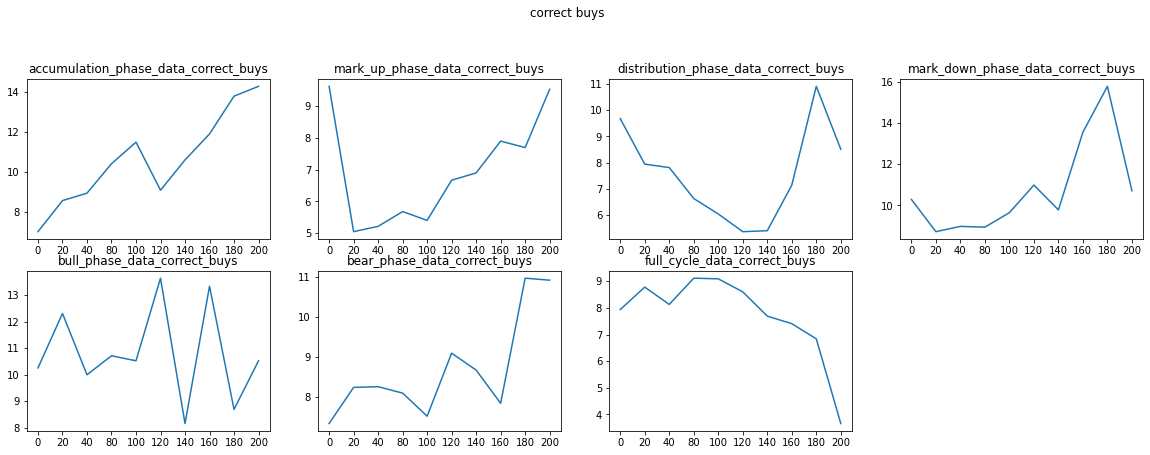

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

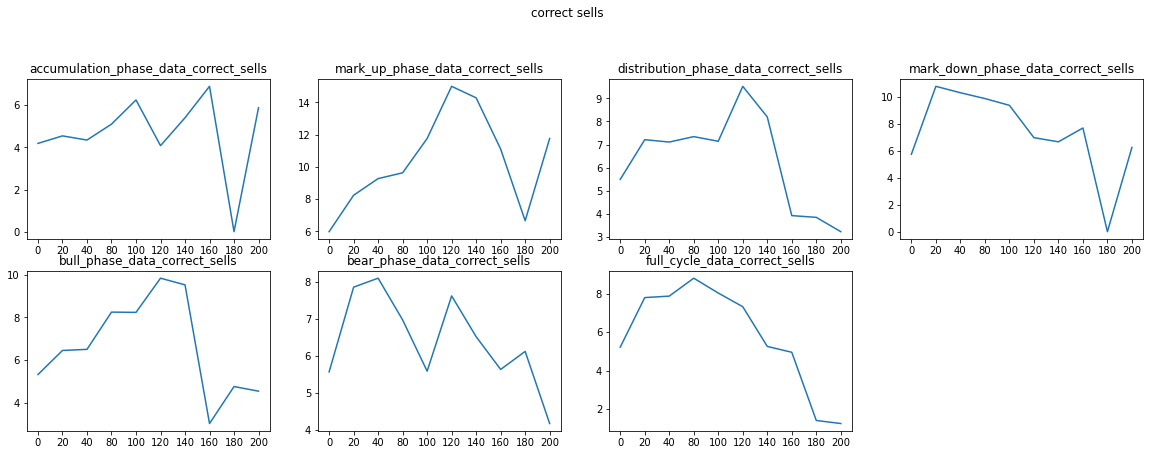

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

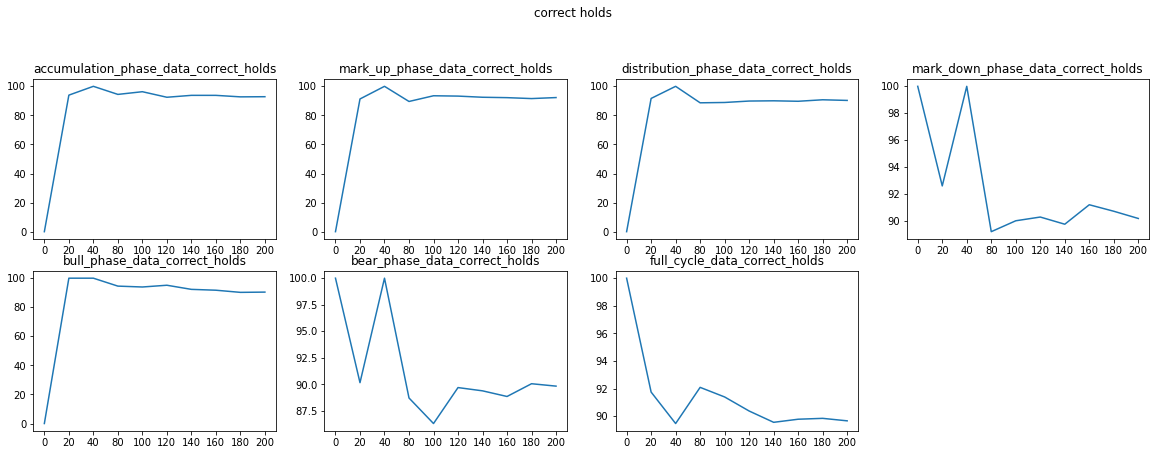

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

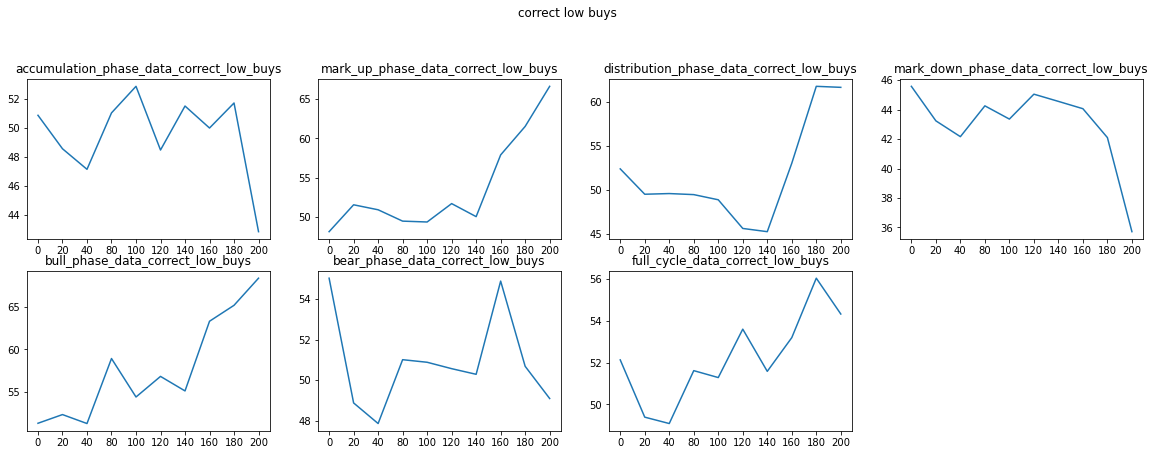

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

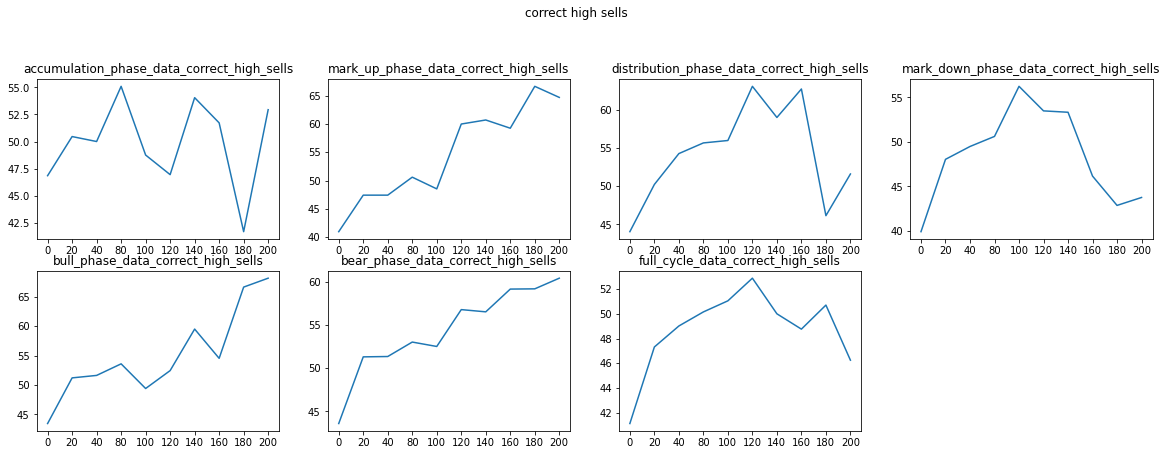

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

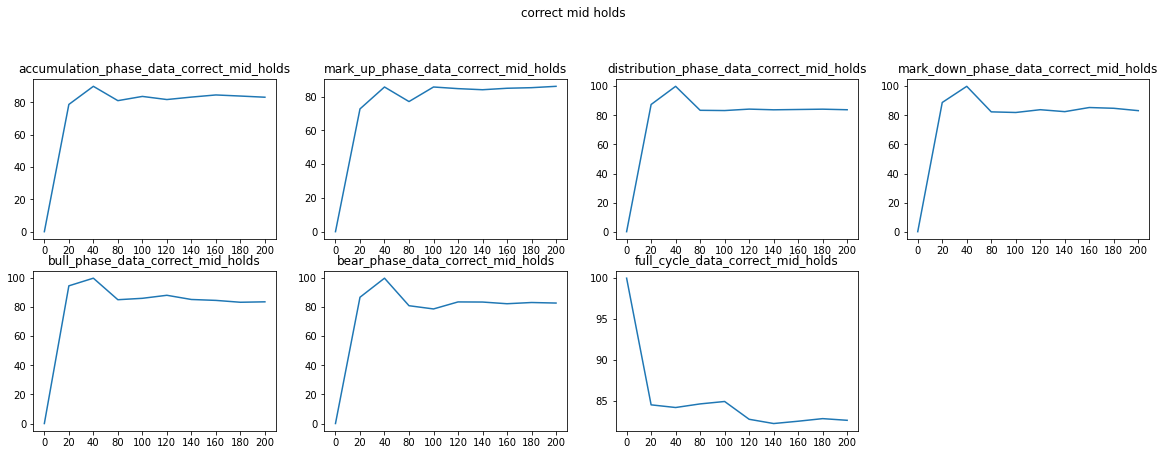

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

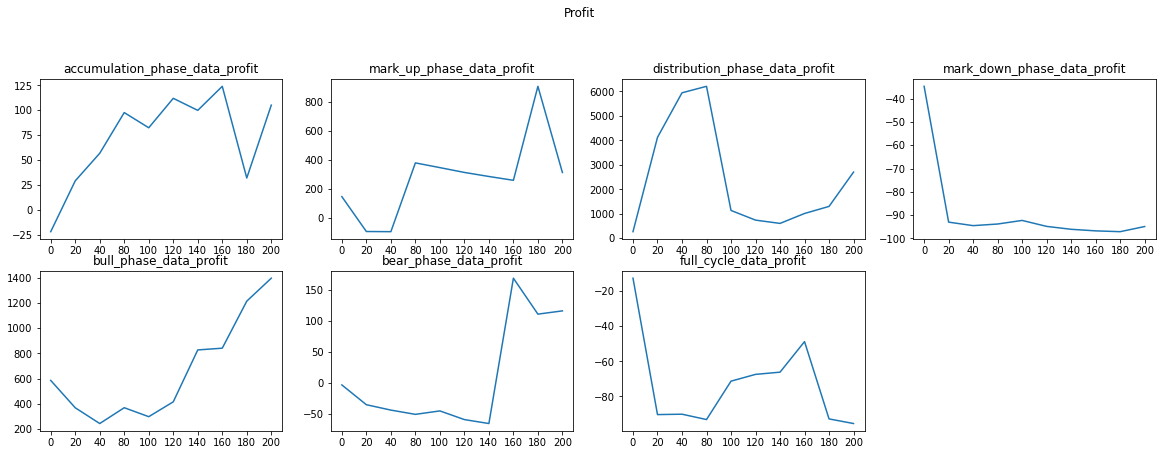

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")